In [47]:
import os
from transformers import DetrImageProcessor, DetrForObjectDetection, DetrFeatureExtractor, DetrConfig
import torch
import torchvision
from PIL import Image, ImageDraw
import pytorch_lightning as pl
import numpy as np

In [41]:
# Convert CSV to COCO format
        # We need to convert the CSV to a JSON format like that:
        # annotation{
        # "id" : int, "image_id" : int, "category_id" : int, "segmentation" : RLE or [polygon], "area" : float, "bbox" : [x,y,width,height], "iscrowd" : 0 or 1,
        # }
        # 
        # categories[{
        # "id" : int, "name" : str, "supercategory" : str,
        # }]

def convert_csv_to_coco(csv_path, img_path, json_path):
  import csv
  import json
  from collections import defaultdict

  # Create the categories
  categories = []
  categories.append({"id": 0, "name": "background", "supercategory": ""})
  categories.append({"id": 1, "name": "rebar", "supercategory": ""})

  # Create the annotations
  annotations = []
  images = []
  image_ids = []
  annotation_id = 0
  with open(csv_path, newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        # row contains the follwing information [image_name, xmin ymin xmax ymax]
        # print(row)
        image_name = row[0]
        coordinates = row[1].split(" ")
        xmin = float(coordinates[0])
        ymin = float(coordinates[1])
        xmax = float(coordinates[2])
        ymax = float(coordinates[3])
        area = (xmax -xmin) * (ymax - ymin)
        # Extract the image id from the image name
        image_id = int(image_name.split("_")[1])
        annotations.append({"id": annotation_id, "image_id": image_id, "category_id": 1, "segmentation": [], "area": area,
                            "bbox": [xmin, ymin, xmax -xmin,ymax-ymin], "iscrowd": 0})
  
  # Create the images
        if image_id not in image_ids:
            image_ids.append(image_id)
            # Get the image size
            image = Image.open(os.path.join(img_path, image_name))
            width, height = image.size
            images.append({"id": image_id, "width": width, "height": height, "file_name": image_name})

  # Create the JSON
  data = {"info": {}, "licenses": {}, "images": images, "annotations": annotations, "categories": categories}
  with open(json_path, 'w') as outfile:
    json.dump(data, outfile)


In [43]:
# Convert the CSV to COCO format
convert_csv_to_coco("RebarDSC/annotations/100_percent_train.csv", "RebarDSC/images", "RebarDSC/annotations/100_percent_train.json")
convert_csv_to_coco("RebarDSC/annotations/test.csv", "RebarDSC/images", "RebarDSC/annotations/test.json")

In [44]:
# Create the Data loader
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, train=True):
        ann_file = os.path.join(img_folder, "annotations/100_percent_train.json" if train else "annotations/test.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target


In [45]:
# Set up pre-trained model
pretrained_model = "facebook/detr-resnet-50"

img_folder = "RebarDSC"

feature_extractor = DetrFeatureExtractor.from_pretrained(pretrained_model)

train_dataset = CocoDetection(img_folder=f'{img_folder}', feature_extractor=feature_extractor)
val_dataset = CocoDetection(img_folder=f'{img_folder}', feature_extractor=feature_extractor, train=False)

loading annotations into memory...
Done (t=0.58s)
creating index...
index created!
loading annotations into memory...
Done (t=0.41s)
creating index...
index created!


In [46]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 1125
Number of validation examples: 1000


Image n°1435


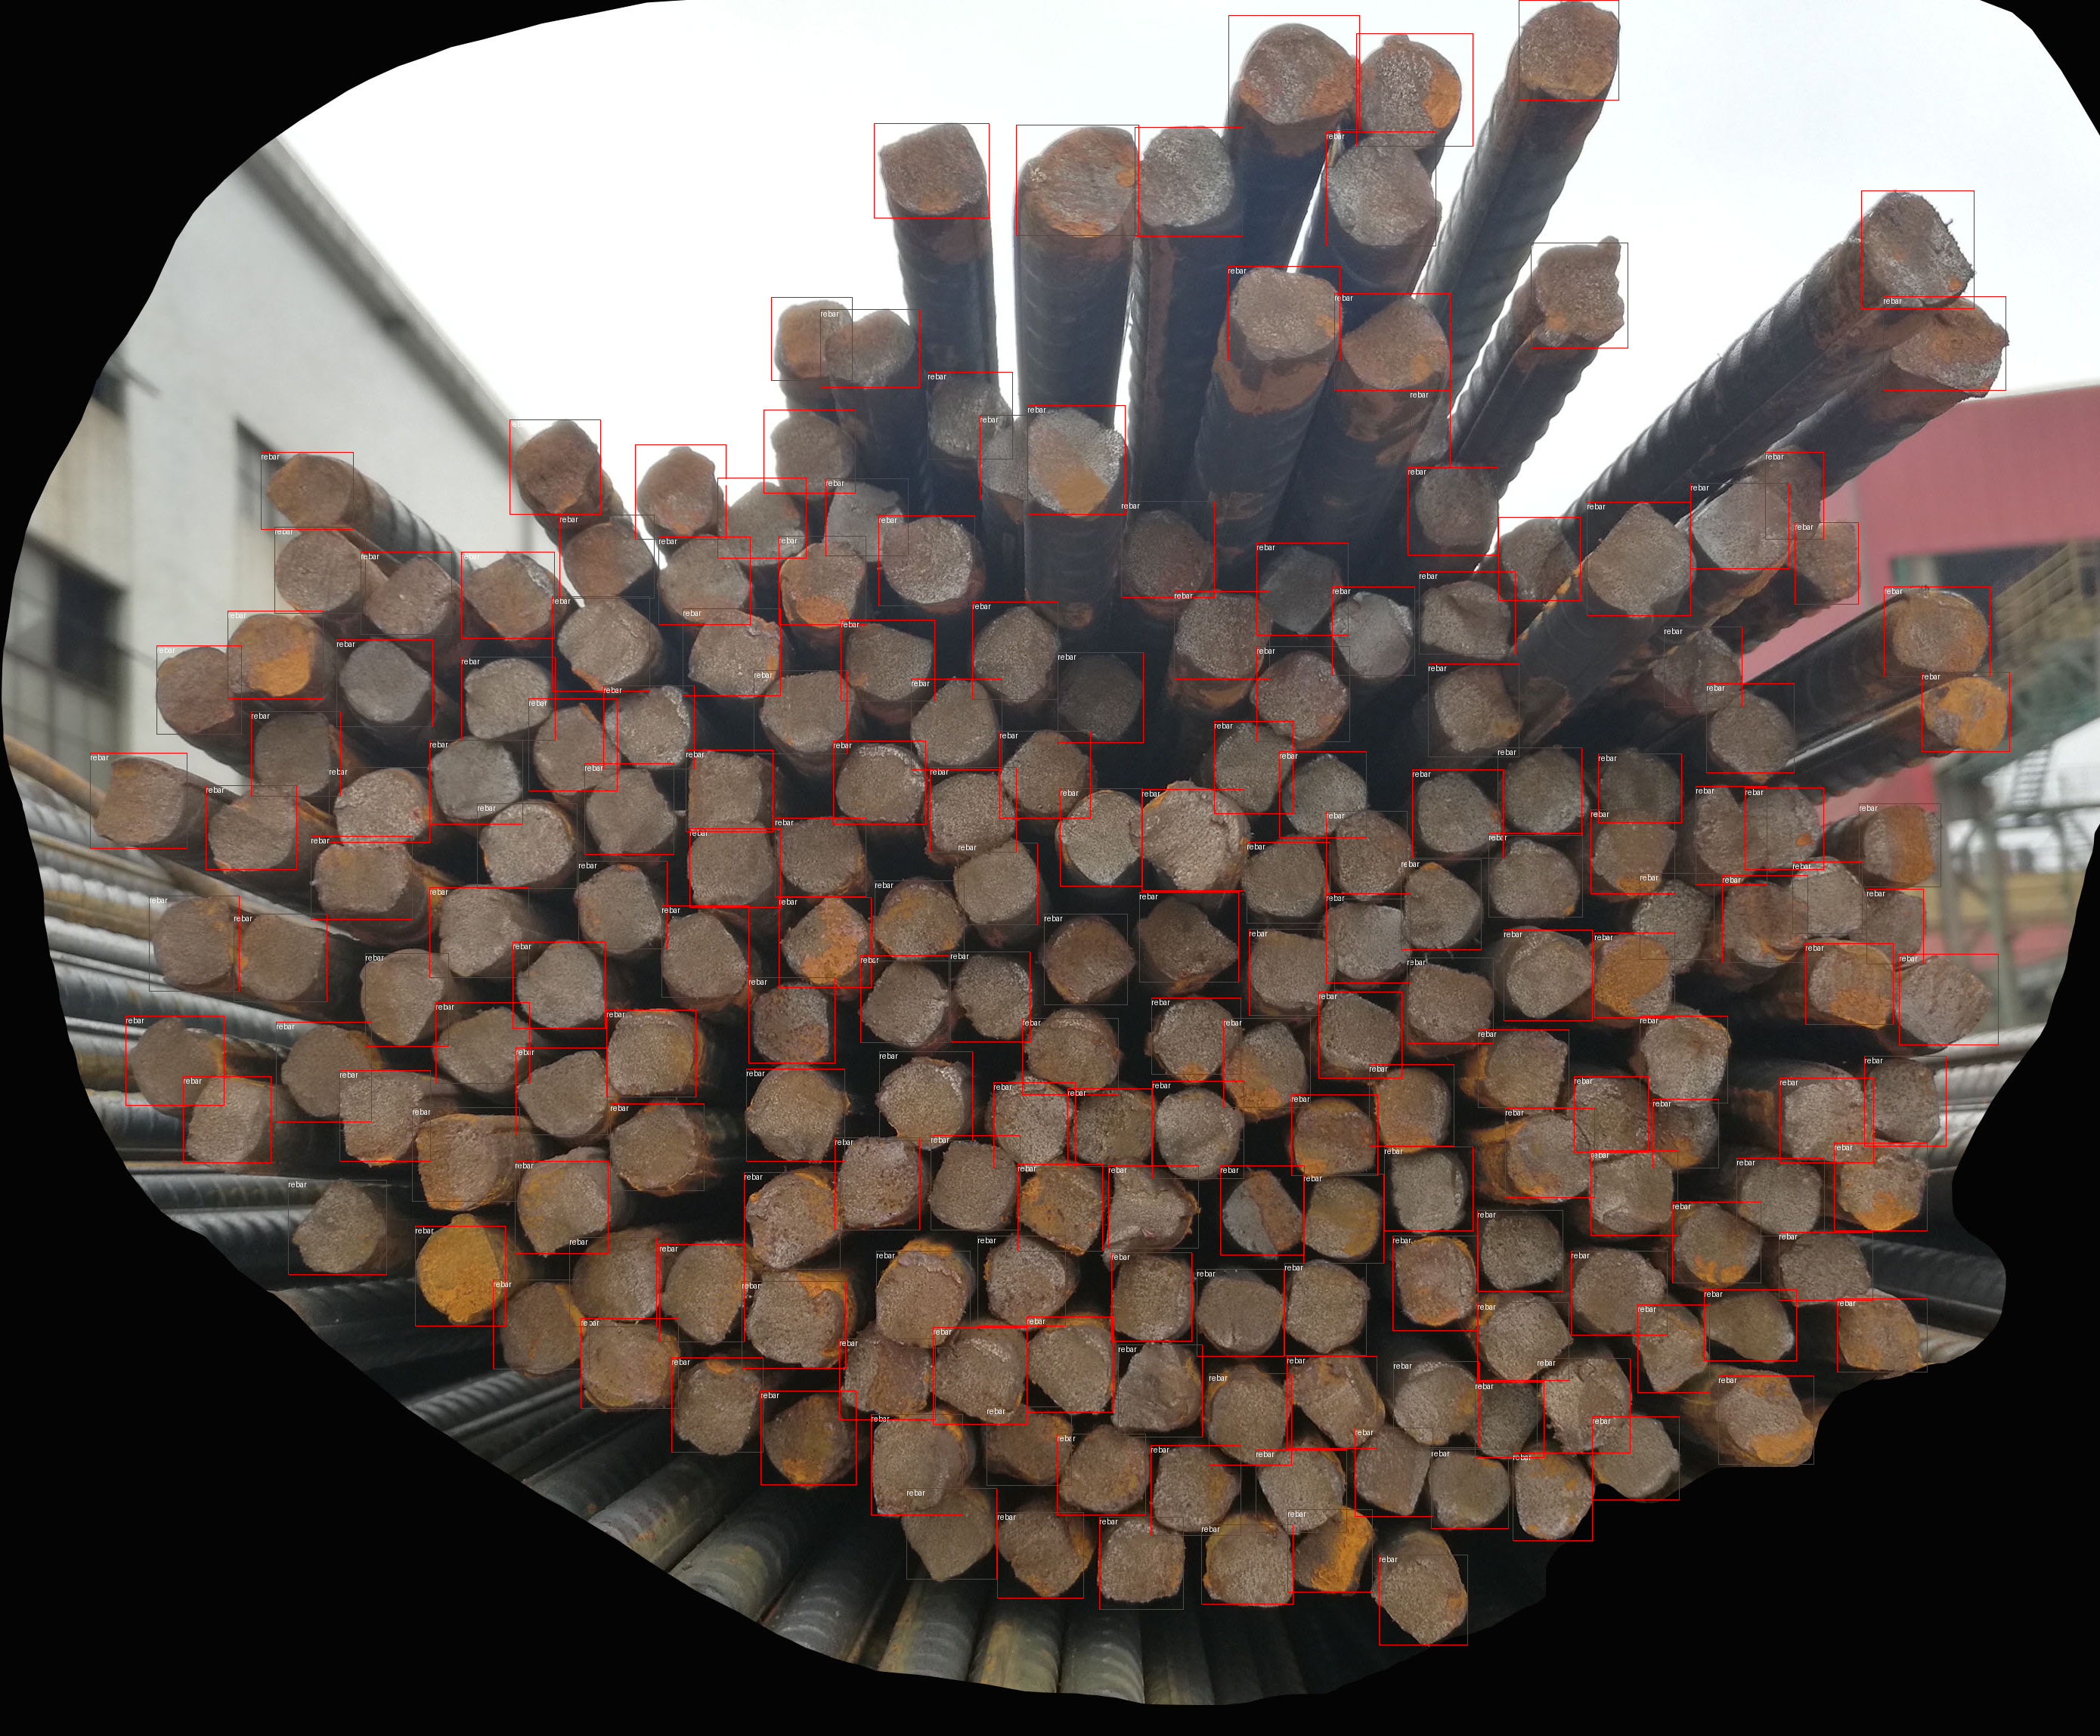

In [49]:
# Let's check one example

image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join(f'{img_folder}/images', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

In [12]:
# The model needs finetunning to detect rebar
class Detr(pl.LightningModule):

     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         self.model = DetrForObjectDetection.from_pretrained(pretrained_model, 
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs
     
     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)
        
        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

NameError: name 'pl' is not defined

In [11]:
# Replace the pre-trained head with a new one
print(model)
# model.class_embed = Linear(in_features=model.class_embed.in_features, out_features=num_labels+1)

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

In [14]:
config

DetrConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "architectures": [
    "DetrForObjectDetection"
  ],
  "attention_dropout": 0.0,
  "auxiliary_loss": false,
  "backbone": "resnet50",
  "backbone_config": null,
  "bbox_cost": 5,
  "bbox_loss_coefficient": 5,
  "class_cost": 1,
  "classifier_dropout": 0.0,
  "d_model": 256,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "dice_loss_coefficient": 1,
  "dilation": false,
  "dropout": 0.1,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 2048,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_coefficient": 0.1,
  "giou_cost": 2,
  "giou_loss_coefficient": 2,
  "init_std": 0.02,
  "init_xavier_std": 1.0,
  "is_encoder_decoder": true,
  "mask_loss_coefficient": 1,
  "max_position_embeddings": 1024,
  "model_type": "detr",
  "num_channels": 3,
  "num_hidden_layers": 6,
  "num_queries": 100,
  "position_embedding_type": "sine",
  "scale_embed